# Chapter 04. Experiment Management
---

## 4.1 Experiments, Trials, and Components
---

In [1]:
# Change into the notebooks directory.
%cd /root/sagemaker-course/notebooks/

/root/sagemaker-course/notebooks


In [31]:
import datetime

import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role

# S3 bucket information
BUCKET = 'sagemaker-course-20200517'
PREFIX = 'mnist'
LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'
print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

# Session variables we'll use throughout the notebook
sagemaker_session = sagemaker.Session()
boto_session = sagemaker_session.boto_session
sagemaker_client = boto_session.client('sagemaker')
role = get_execution_role()

Artifacts will be written to s3://sagemaker-course-20200517/mnist


In [4]:
from smexperiments.experiment import Experiment

Experiment?

Init signature: Experiment(sagemaker_boto_client, **kwargs)
Docstring:     
An Amazon SageMaker experiment, which is a collection of related trials.

New experiments are created by calling :meth:`~smexperiments.experiment.Experiment.create`. Existing
experiments can be reloaded by calling :meth:`~smexperiments.experiment.Experiment.load`. You can
add a new trial to an Experiment by calling :meth:`~smexperiments.experiment.Experiment.create_trial`.
To remove a Trial from an experiment, delete the trial.

Examples:
    .. code-block:: python

        from smexperiments import experiment

        my_experiment = experiment.Experiment.create(experiment_name='AutoML')
        my_trial = my_experiment.create_trial(trial_name='random-forest')

        for exp in experiment.Experiment.list():
            print(exp)
        for trial in my_experiment.list_trials():
            print(trial)

        my_trial.delete()
        my_experiment.delete()

Attributes:
    experiment_name (str): The name

In [5]:
from smexperiments.trial import Trial

Trial?

Init signature: Trial(sagemaker_boto_client, **kwargs)
Docstring:     
An execution of a data-science workflow with an experiment.

Consists of a list of trial component objects, which document individual activities within the workflow.

Examples:
    .. code-block:: python

        from smexperiments import trial, experiment, tracker

        my_experiment = experiment.Experiment.create(experiment_name='AutoML')
        my_trial = trial.Trial.create('AutoML')

        my_tracker = tracker.Tracker.create()
        # log hyper parameter of learning rate
        my_tracker.log_parameter('learning_rate', 0.01)
        my_trial.add_trial_component(my_tracker)

        for trial_component in my_trial.list_trial_components():
            print(trial_component)

        my_trial.remove_trial_component(my_tracker)
        my_trial.delete()

Attributes:
    trial_name (str): The name of the trial.
    experiment_name (str): The name of the trial's experiment.
File:           /opt/conda/lib/pyth

In [6]:
from smexperiments.trial_component import TrialComponent

TrialComponent?

Init signature: TrialComponent(sagemaker_boto_client, **kwargs)
Docstring:     
This class represents a SageMaker trial component object.

A trial component is a stage in a trial.

Trial components are created automatically within the SageMaker runtime and may not be created directly.
To automatically associate trial components with a trial and experiment supply an experiment config when creating a
job. For example: https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html

Attributes:
    trial_component_name (str): The name of the trial component. Generated by SageMaker from the name of the
        source job with a suffix specific to the type of source job.
    trial_component_arn (str): The ARN of the trial component.
    display_name (str): The name of the trial component that will appear in UI, such as SageMaker Studio.
    source (obj): A TrialComponentSource object with a source_arn attribute.
    status (str): Status of the source job.
    start_time (datetime

### 4.1.2 Use Case: Training a Tensorflow Model on MNIST
---

In [16]:
training_data_bucket = f'sagemaker-sample-data-{boto_session.region_name}'
training_data_prefix = 'tensorflow/mnist'

training_data_uri = f's3://{training_data_bucket}/{training_data_prefix}'
training_data_uri

's3://sagemaker-sample-data-us-east-2/tensorflow/mnist'

In [17]:
boto_session.client('s3').list_objects(
    Bucket=training_data_bucket,
    Prefix=training_data_prefix)

{'ResponseMetadata': {'RequestId': '577D30F649208E0F',
  'HostId': 'O/qhe406McQGdazjFVCvBLipFgx+dJOWVS4di93+nNI6CsMbsSCY8H24OloezRcTFSqlm1vcOyI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'O/qhe406McQGdazjFVCvBLipFgx+dJOWVS4di93+nNI6CsMbsSCY8H24OloezRcTFSqlm1vcOyI=',
   'x-amz-request-id': '577D30F649208E0F',
   'date': 'Mon, 18 May 2020 13:27:22 GMT',
   'x-amz-bucket-region': 'us-east-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'tensorflow/mnist/',
   'LastModified': datetime.datetime(2018, 11, 13, 18, 49, 37, tzinfo=tzlocal()),
   'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'Size': 0,
   'StorageClass': 'STANDARD'},
  {'Key': 'tensorflow/mnist/eval_data.npy',
   'LastModified': datetime.datetime(2019, 1, 24, 23, 37, 44, tzinfo=tzlocal()),
   'ETag': '"999d245abdf1f6f45d8b516ef04367e0-4"',
   'Size': 31360128,
   'StorageCl

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py).

In [19]:
!pygmentize '../scripts/tf/tensorflow_mnist.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    mod

In [32]:
# Create the Experiment
experiment_name = f"tf-mnist-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
description = "Classification of mnist hand-written digits using tensorflow 2"

tf_experiment = Experiment.create(experiment_name=experiment_name, 
                                  description=description, 
                                  sagemaker_boto_client=sagemaker_client)

In [36]:
# Create the Trial
trial_name = f"tf-trial-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"

tf_trial = Trial.create(trial_name=trial_name, 
                        experiment_name=tf_experiment.experiment_name,
                        sagemaker_boto_client=sagemaker_client)

In [46]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point='../scripts/tf/tensorflow_mnist.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    code_location=f"s3://{BUCKET}/{PREFIX}",
    output_path=f"s3://{BUCKET}/{PREFIX}",
    base_job_name='tf-mnist',
    py_version='py3',
    framework_version='2.1.0',
    enable_sagemaker_metrics=True)

**Note: The next cell takes 3-5 minutes to return.**

In [ ]:
experiment_config = {
        "TrialName": tf_trial.trial_name,
        "TrialComponentDisplayName": "Training",
    }

# Now associate the estimator with the Experiment and Trial
tf_estimator.fit(inputs={'training': training_data_uri},
                 experiment_config=experiment_config)

### 4.1.3 SageMaker Studio Walk-thru
---

At this point you can view the `Experiment` metadata by clicking on the beaker icon in the vertical navigation bar on the left-side of your screen.

## 4.2 Tracking Distributed Hyperparameter Search with Multiple Trials
---

In [49]:
from matplotlib import pyplot as plt
import pandas as pd
from torchvision import datasets, transforms

%config InlineBackend.figure_format = 'retina'

In [51]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Download, load, and transform the data.
train_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=True, transform=transform, download=True)
test_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=False, transform=transform, download=True)

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


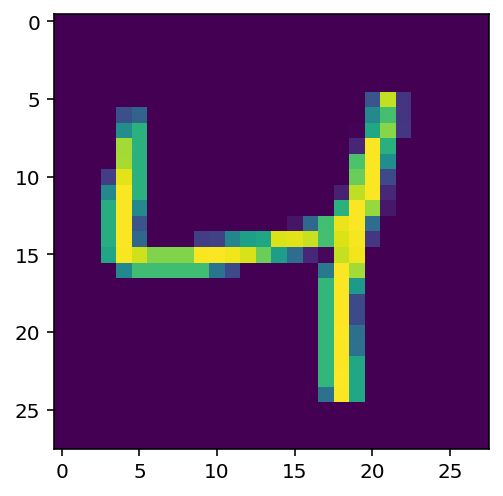

In [52]:
plt.imshow(train_set.data[2].numpy());

In [53]:
inputs = sagemaker_session.upload_data(
    path=LOCAL_DATA_DIRECTORY,
    bucket=BUCKET,
    key_prefix=PREFIX)

In [56]:
from smexperiments.tracker import Tracker

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sagemaker_client) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

In [58]:
experiment_name = f"torch-mnist-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
description = "Classification of mnist hand-written digits with pytorch."

mnist_experiment = Experiment.create(experiment_name=experiment_name,
                                     description=description, 
                                     sagemaker_boto_client=sagemaker_client)

**Note: This takes ~15 minutes to return.**

In [ ]:
from sagemaker.pytorch import PyTorch

hidden_channel_trial_name_map = {} # Keep references to each Trial object

# If you want to run the following training jobs asynchronously, you may need to increase
# your resource limit. Otherwise, you can run them sequentially.
for i, num_hidden_channel in enumerate([2, 5, 10]):
    
    # create Trial object
    trial_name = f"torch-{num_hidden_channel}-hidden-channels-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sagemaker_client,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # Associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(tracker.trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='../scripts/torch/pytorch_mnist.py',
        role=role,
        sagemaker_session=sagemaker_session,
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        code_location=f"s3://{BUCKET}/{PREFIX}",
        output_path=f"s3://{BUCKET}/{PREFIX}",
        base_job_name='torch-mnist',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True,
    )
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

### 4.2.3 SageMaker Studio Walk-thru
---

At this point you can view the `Experiment` metadata by clicking on the beaker icon in the vertical navigation bar on the left-side of your screen.

## 4.3 Analyzing Experiment Results
---

In [62]:
from sagemaker.analytics import ExperimentAnalytics

search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [63]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,torch-mnist-2020-05-18-15-42-42-697-aws-traini...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,torch-mnist-2020-05-18-15-35-12-714-aws-traini...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
2,torch-mnist-2020-05-18-15-38-57-675-aws-traini...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2


In [64]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [65]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2020-05-18-152230-dmwv,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,torch-mnist-2020-05-18-15-35-12-714-aws-traini...,Training,NaN,NaN,arn:aws:sagemaker:us-east-2:209970524256:train...,520713654638.dkr.ecr.us-east-2.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0
